Version 5. The intent here is to create two query focussed data sets from the original event data. Each should be indexed in such a way to enable easy analysis of the data whilst containing all relevant data. The two data sets will be:
<ul><li>Missions: New state every time a mission changes orbit and if a component is added or removed. To include a List of travellers and craft for every state. Consider collapsing state changes that occur at the same time.</li>
    <li>Components: New state every time the component changes mission and if its mission changes orbit. To include the orbit of the mission.</li></ul>

Spaceflight data.
Some questions to ask (<em>Emphasised</em> text indicates as yet unanswered questions): 
<ul>
    <li>Who's been blasted into space the most times?</li>
    <li>Who's been to the most different orbits?</li>
    <li>Which spacecraft has been blasted into space the most times? And how many have been used more than once?</li>
    <li>Who's spent the most time in space?</li>
    <li>Which re-usable spacecraft has been used the most frequently?</li>
    <li>What is the largest number of people to have been on the same spacecraft/mission at the same time? <em>(and when was this?)</em></li>
    <li><em>What is the largest number of free-flying missions to be in orbit at the same time? (and when was this?)</em></li>
</ul>

<h2>Data Prep</h2>

In [1]:
import numpy as np
import pandas as pd

Read in data file

In [2]:
el = pd.read_csv("data/sftl-2020.txt", sep="\t", header=0, parse_dates=[0], dtype={'eventType': 'category'})
el

,date,subject,eventType,object
0,1960-07-29,Mercury_No.4,SUPPORTS,Mercury-Atlas_1
1,1960-07-29,Mercury-Atlas_1,DEPARTS,Earth
2,1960-07-29,Mercury-Atlas_1,ARRIVES,Sub_Orbital
3,1960-07-29,Mercury-Atlas_1,ENDS,NaN
4,1960-08-19,Vostok_1K_KS2,SUPPORTS,Korabl-Sputnik_2
...,...,...,...,...
5320,2020-04-17,Andrew_R._Morgan,JOINS,Soyuz_MS-15
5321,2020-04-17,Oleg_Skripochka,JOINS,Soyuz_MS-15
5322,2020-04-17,Jessica_Meir,JOINS,Soyuz_MS-15
5323,2020-04-17,Soyuz_MS-15,DEPARTS,LEO


Some explanation of the data.</br>
The events describe changes to the state of three and a bit different types of object. The three main types are Mission, Orbit and Component. A mission is a slightly abstract concept that groups together the components for a particular purpose. All the components of a mission are physically connected and share a set of orbital ephemeris. An orbit is a rough grouping of different orbits. E.g. LEO for all low-Earth-orbits. Components are further sub-types into travellers and spacecraft. Travellers are people and animals that have been sent into space. Spacecraft are the ships that carried them. The eventType indicates the type of objects in question as follows:
<ul>
    <li>ARRIVES, DEPARTS and ENDS: The subject of the event is a mission, the object is an orbit.</li>
    <li>JOINS: The subject is a traveller and the object is a mission.</li>
    <li>SUPPORTS: The subject is a spacecraft and the object is a mission.</li>
</ul>  
Note that missions can exist without any craft assigned to them. This is typical for missions to space stations whereby the spacecraft becomes part of the space station mission but it's original mission continues until such time as the spacecraft un-docks and returns to Earth.</br>
Timestamps are only accurate to the nearest day but the order that the events occur is cronologically correct (sort of) and therefore shouldn't be ignored.</br>
I can't remember what BREAK events are for. I think it might be to separate groups of events that happen on the same day.

Check the number of different types of events

In [3]:
el.eventType.unique()

[SUPPORTS, DEPARTS, ARRIVES, ENDS, JOINS, BREAK]
Categories (6, object): [SUPPORTS, DEPARTS, ARRIVES, ENDS, JOINS, BREAK]

Pull out all of the unique components and set up a table to track their state.

In [4]:
componentevents = el[(el['eventType']=="SUPPORTS")|(el['eventType']=="JOINS")]
c = componentevents[["subject","eventType","object"]].groupby(by=["subject","eventType"], observed=True).count()
c.reset_index("eventType", inplace=True)
c["Type"]=c["eventType"].map({'SUPPORTS': 'craft', 'JOINS': 'traveller'})
c.drop("eventType", axis=1, inplace=True)
c.rename(columns={"object": "EventCount"}, inplace=True)
c.index.rename("component", inplace=True)
c["mission"] = None
c["currentstate"] = None
c

,EventCount,Type,mission,currentstate
component,,,,
7K-L1 K146,1,craft,None,None
7K-L1 K154,1,craft,None,None
7K-L1 Z4,1,craft,None,None
Abdul_Ahad_Mohmand,3,traveller,None,None
Aidyn_Aimbetov,3,traveller,None,None
...,...,...,...,...
Zarya,1,craft,None,None
Zhai_Zhigang,1,traveller,None,None
Zhang_Xiaoguang,3,traveller,None,None


Do the same for missions.

In [5]:
missionevents = el[(el['eventType']=="DEPARTS")|(el['eventType']=="ARRIVES")]
m = pd.DataFrame(index = missionevents.subject.unique())
m["orbit"]=None
m["currentstate"]=None
m["craft"]=None
m["travellers"]=None
m

,orbit,currentstate,craft,travellers
Mercury-Atlas_1,None,None,None,None
Korabl-Sputnik_2,None,None,None,None
Korabl-Sputnik_3,None,None,None,None
Mercury-Redstone_1A,None,None,None,None
Unamed_Vostok_Flight1,None,None,None,None
...,...,...,...,...
New_Shepard#11,None,None,None,None
Soyuz_MS-13,None,None,None,None
Soyuz_MS-15,None,None,None,None
Boe-OFT,None,None,None,None


Track the history of missions and components. This needs to be done at the same time to keep track of relationships between the two. Essentially it's converting a list of events into a list (two lists) of states.

In [6]:
ms = []
def record_mission_state(mission, date, shortEvent):
    msr = {}
    # find the id of the last state recorded for new mission
    laststateindex = m.at[mission,"currentstate"]        
    # Create a new state record for the mission.
    msr["startevent"] = shortEvent
    msr["mission"] = mission
    msr["startdate"] = date
    msr["enddate"] = pd.Timestamp.today()
    msr["orbit"] = m.at[mission,"orbit"]

    # Craft and traveller lists need to by copied (assuming they're not the None object)
    craftList = m.at[mission,"craft"]
    if not(craftList is None):
        msr["craft"] = craftList.copy()
    else:
        msr["craft"] = craftList # I.e. pass by reference
    travellerList = m.at[mission,"travellers"]
    if not(travellerList is None):
        msr["travellers"] = travellerList.copy()
    else:
        msr["travellers"] = travellerList
        
    msr["pred"] = laststateindex # I.e. pass by reference
    msr["succ"] = None
    # Append the new state record to the list
    ms.append(msr)
    # Update the mission's pointer its the last known state record
    if len(ms) > 0:
        m.at[mission, "currentstate"] = len(ms) - 1
    else:
        m.at[mission, "currentstate"] = None

    # Update the the previous state of the mission (if there was one)
    if not(laststateindex is None):
        try:
            ms[laststateindex]["enddate"] = row["date"]
            ms[laststateindex]["succ"] = m.at[mission, "currentstate"]
        except IndexError:
            print("Index error on mission state array access.")
            print("Event Date: " + str(date))
            print("Length of mission state array: " + str(len(ms)))
            print("laststateindex: " + str(laststateindex))
            print("Mission record: " + str(m.loc[mission]))

cs = []    
def record_component_state(component, date, shortEvent):
    csr = {}
    # find the id of the last state recorded for this component
    laststateindex = c.at[component,"currentstate"]
    # Find the mission to which the component is assigned
    mission = c.at[component,"mission"]

    # Create a record for the new state of this component
    csr["startevent"] = shortEvent
    csr["startdate"] = row["date"]
    csr["enddate"] = pd.Timestamp.today()
    csr["component"] = component
    csr["type"] = c.at[component, "Type"]
    csr["mission"] = c.at[component, "mission"]
    if not(mission is None):
        csr["orbit"] = m.at[mission, "orbit"]
    else:
        csr["orbit"] = None
    csr["pred"] = laststateindex
    csr["succ"] = None

    cs.append(csr)
    if len(cs) > 0:
        c.at[component, "currentstate"] = len(cs) - 1
    else:
        c.at[component, "currentstate"] = None 

    # Update the the previous state of this component (if there was one)
    if not(laststateindex is None):
        try:
            cs[laststateindex]["enddate"] = row["date"]
            cs[laststateindex]["succ"] = c.at[component, "currentstate"]
        except IndexError:
            print("Index error on component state array access.")
            print("Event Date: " + str(date))
            print("Length of component state array: " + str(len(cs)))
            print("laststateindex: " + str(laststateindex))
            print("Component record: " + str(c.loc[component]))




for index, row in el.iterrows():
    # For events where the subject is a component:
    # 1. Create a new component state recording the new mission.
    # 2. Create two new mission states - one for the new mission and one for the old one.
    
    shortEvent = str(row["subject"]) + " " + str(row["eventType"]) + " " + str(row["object"])
    
    if row["eventType"] == "SUPPORTS" or row["eventType"] == "JOINS":
        mission = row["object"]
        component = row["subject"]
       
        # Remember the mission to which this component was previously assigned
        prevmission = c.at[component, "mission"]
        # Update the component record with the new mission
        c.at[component, "mission"] = mission
        # Dump the current component state to a new state record.
        record_component_state(component, row["date"], shortEvent)

        # Add the component to it's new mission
        if row["eventType"] == "SUPPORTS":
            if not(m.at[mission, "craft"] is None) and len(m.at[mission, "craft"])>0:
                m.at[mission, "craft"].append(component)
            else:
                m.at[mission, "craft"] = [component]
        else:
            if not(m.at[mission, "travellers"] is None) and len(m.at[mission, "travellers"])>0:
                m.at[mission, "travellers"].append(component)
            else:
                m.at[mission, "travellers"] = [component]
        # Dump the current state of the new mission to the mission state list
        record_mission_state(mission, row["date"], shortEvent)
        
        # Remove the component from its previous mission (if there was one)
        if not(prevmission is None):
            try:
                if row["eventType"] == "SUPPORTS":
                    m.at[prevmission, "craft"].remove(component)
                else:
                    m.at[prevmission, "travellers"].remove(component)
            except ValueError:
                print("Tried to remove a component from a mission when it wasn't there")
                print("Mission: " + prevmission)
                print("Component: " + component)
                print("Event: " + row)
            # Dump the current state of the new mission to the mission state list
            record_mission_state(prevmission, row["date"], shortEvent)        


    elif row["eventType"] == "ARRIVES" or row["eventType"] == "DEPARTS":
        mission = row["subject"]
        # Remember the previous orbit
        prevorbit = m.at[mission, "orbit"]
        if row["eventType"] == "ARRIVES":
            orbit = row["object"]
        elif row["eventType"] == "DEPARTS":
            orbit = "Leaving_" + str(row["object"])
            # For DEPART events, check that the mission is departing the orbit is was previously assigned.
            if not(prevorbit is None) and row["object"] != prevorbit:
                print("WARNING: Mission "
                      + mission
                      + " departing "
                      + row["object"]
                      + " but previously assigned "
                      + str(prevorbit)) # Could be None         
        # Record the new orbit
        m.at[mission, "orbit"] = orbit

        # Dump the current state of the mission to a new mission state object
        record_mission_state(mission, row["date"], shortEvent)
        
        # If the mission currently has any components assigned to it, create new states for them too.
        if not(m.at[mission, "travellers"] is None):
            for comp in m.at[mission, "travellers"]:
                record_component_state(comp, row["date"], shortEvent)
        if not(m.at[mission, "craft"] is None):
            for comp in m.at[mission, "craft"]:
                record_component_state(comp, row["date"], shortEvent)
                
    elif row["eventType"] == "ENDS":
        mission = row["subject"]
        m.at[mission, "orbit"] = None
        if not(m.at[mission, "travellers"] is None):
            for comp in m.at[mission, "travellers"]:
                c.at[comp, "mission"] = None
                record_component_state(comp, row["date"], shortEvent)
        m.at[mission, "travellers"] = None
        if not(m.at[mission, "craft"] is None):
            for comp in m.at[mission, "craft"]:
                c.at[comp, "mission"] = None
                record_component_state(comp, row["date"], shortEvent)
        m.at[mission, "craft"] = None
        record_mission_state(mission, row["date"], shortEvent)       

 
 

In [7]:
dfms = pd.DataFrame(ms)
dfms[(dfms["mission"]=="Mir")]

,startevent,mission,startdate,enddate,orbit,craft,travellers,pred,succ
2094,Mir_Core SUPPORTS Mir,Mir,1986-02-20,1986-02-20 00:00:00.000000,None,[Mir_Core],None,NaN,2095.0
2095,Mir DEPARTS Earth,Mir,1986-02-20,1986-02-20 00:00:00.000000,Leaving_Earth,[Mir_Core],None,2094.0,2096.0
2096,Mir ARRIVES LEO,Mir,1986-02-20,1986-03-15 00:00:00.000000,LEO,[Mir_Core],None,2095.0,2104.0
2104,Soyuz_T-15_Spacecraft SUPPORTS Mir,Mir,1986-03-15,1986-03-15 00:00:00.000000,LEO,"[Mir_Core, Soyuz_T-15_Spacecraft]",None,2096.0,2106.0
2106,Vladimir_Solovyov_(cosmonaut) JOINS Mir,Mir,1986-03-15,1986-03-15 00:00:00.000000,LEO,"[Mir_Core, Soyuz_T-15_Spacecraft]",[Vladimir_Solovyov_(cosmonaut)],2104.0,2108.0
...,...,...,...,...,...,...,...,...,...
4477,Sergei_Zalyotin JOINS Soyuz_TM-30,Mir,2000-06-16,2000-06-16 00:00:00.000000,LEO,"[Mir_Core, Kvant-1_Module, Kavant-2_Module, Kr...",[Aleksandr_Kaleri],4475.0,4479.0
4479,Aleksandr_Kaleri JOINS Soyuz_TM-30,Mir,2000-06-16,2001-03-23 00:00:00.000000,LEO,"[Mir_Core, Kvant-1_Module, Kavant-2_Module, Kr...",[],4477.0,4745.0
4745,Mir DEPARTS LEO,Mir,2001-03-23,2001-03-23 00:00:00.000000,Leaving_LEO,"[Mir_Core, Kvant-1_Module, Kavant-2_Module, Kr...",[],4479.0,4746.0
4746,Mir ARRIVES Sub_Orbital,Mir,2001-03-23,2001-03-23 00:00:00.000000,Sub_Orbital,"[Mir_Core, Kvant-1_Module, Kavant-2_Module, Kr...",[],4745.0,4747.0


In [8]:
dfcs = pd.DataFrame(cs)
    
dfcs[(dfcs["component"] == "Valeri_Polyakov")].sort_values(by="startdate")

,startevent,startdate,enddate,component,type,mission,orbit,pred,succ
3274,Valeri_Polyakov JOINS Soyuz_TM-6,1988-08-29,1988-08-29 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-6,None,NaN,3277.0
3277,Soyuz_TM-6 DEPARTS Earth,1988-08-29,1988-08-29 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-6,Leaving_Earth,3274.0,3281.0
3281,Soyuz_TM-6 ARRIVES LEO,1988-08-29,1988-08-29 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-6,LEO,3277.0,3286.0
3286,Valeri_Polyakov JOINS Mir,1988-08-29,1989-04-27 00:00:00.000000,Valeri_Polyakov,traveller,Mir,LEO,3281.0,3421.0
3421,Valeri_Polyakov JOINS Soyuz_TM-7,1989-04-27,1989-04-27 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-7,LEO,3286.0,3424.0
3424,Soyuz_TM-7 DEPARTS LEO,1989-04-27,1989-04-27 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-7,Leaving_LEO,3421.0,3428.0
3428,Soyuz_TM-7 ARRIVES Earth,1989-04-27,1994-01-08 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-7,Earth,3424.0,4770.0
4770,Valeri_Polyakov JOINS Soyuz_TM-18,1994-01-08,1994-01-08 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-18,None,3428.0,4773.0
4773,Soyuz_TM-18 DEPARTS Earth,1994-01-08,1994-01-08 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-18,Leaving_Earth,4770.0,4777.0
4777,Soyuz_TM-18 ARRIVES LEO,1994-01-08,1994-01-08 00:00:00.000000,Valeri_Polyakov,traveller,Soyuz_TM-18,LEO,4773.0,4782.0


<h2>Launch Frequency</h2>

Try and work out who or what has been blasted into space the most times, and the most freqently.

In [9]:
ComponentLaunches = dfcs.loc[((dfcs["orbit"] == "Leaving_Earth")),["component","type","mission","startdate"]]
ComponentLaunchIntervals = ComponentLaunches.groupby(["type","component"]).agg({'mission':'count','startdate': lambda x: x.max() - x.min()})
ComponentLaunchIntervals.rename(columns={"mission": "LaunchCount","startdate":"TotalLaunchInterval"}, inplace=True)
meanLaunchIntervals = ComponentLaunchIntervals[(ComponentLaunchIntervals["LaunchCount"]>1)].apply(lambda row: row["TotalLaunchInterval"] / (row["LaunchCount"]-1), axis=1)
ComponentLaunchIntervals["MeanLaunchInterval"] = meanLaunchIntervals
ComponentLaunchIntervals[(ComponentLaunchIntervals["LaunchCount"]>1)].sort_values(by="MeanLaunchInterval", ascending=True).head(30)

LaunchCount TotalLaunchInterval  \
type      component                                                   
craft     X-15 No.3                           2             34 days   
traveller Joseph_A._Walker                    2             34 days   
craft     SpaceShipOne_X0                     3            105 days   
          New_Shepard_2                       5            317 days   
traveller Susan_L._Still                      2             88 days   
          Gregory_T._Linteris                 2             88 days   
          Roger_K._Crouch                     2             88 days   
          Mike_Melvill                        2            100 days   
craft     Space_Shuttle_Challenger           10           1061 days   
          New_Shepard_3                       5            506 days   
          Mercury_No.8                        2            141 days   
traveller Nick_Hague                          2            154 days   
          Paul_S._Lockhart                    2            171 days   
          Charles_D._Walker                   3            453 days   
craft     SPACEHAB LSM                        2            241 days   
          SPACEHAB LDM                        7           1453 days   
          Space_Shuttle_Discovery            39           9674 days   
          Space_Shuttle_Endeavour            25           6948 days   
          Space_Shuttle_Atlantis             33           9409 days   
          Space_Shuttle_Columbia             28           7949 days   
          SPACEHAB SM                         7           1956 days   
traveller Donald_A._Thomas                    4           1089 days   
          Michael_T._Good                     2            368 days   
          Ellison_S._Onizuka                  2            400 days   
          Aleksei_Yeliseyev                   3            828 days   
          Vladimir_Shatalov                   3            829 days   
          Stephen_G._Bowen                    3            831 days   
craft     VA 102P                             2            418 days   
          VA 102L                             2            418 days   
traveller Robert_L._Crippen                   4           1272 days   

                                         MeanLaunchInterval  
type      component                                          
craft     X-15 No.3                        34 days 00:00:00  
traveller Joseph_A._Walker                 34 days 00:00:00  
craft     SpaceShipOne_X0                  52 days 12:00:00  
          New_Shepard_2                    79 days 06:00:00  
traveller Susan_L._Still                   88 days 00:00:00  
          Gregory_T._Linteris              88 days 00:00:00  
          Roger_K._Crouch                  88 days 00:00:00  
          Mike_Melvill                    100 days 00:00:00  
craft     Space_Shuttle_Challenger        117 days 21:20:00  
          New_Shepard_3                   126 days 12:00:00  
          Mercury_No.8                    141 days 00:00:00  
traveller Nick_Hague                      154 days 00:00:00  
          Paul_S._Lockhart                171 days 00:00:00  
          Charles_D._Walker               226 days 12:00:00  
craft     SPACEHAB LSM                    241 days 00:00:00  
          SPACEHAB LDM                    242 days 04:00:00  
          Space_Shuttle_Discovery  254 days 13:53:41.052631  
          Space_Shuttle_Endeavour         289 days 12:00:00  
          Space_Shuttle_Atlantis          294 days 00:45:00  
          Space_Shuttle_Columbia          294 days 09:46:40  
          SPACEHAB SM                     326 days 00:00:00  
traveller Donald_A._Thomas                363 days 00:00:00  
          Michael_T._Good                 368 days 00:00:00  
          Ellison_S._Onizuka              400 days 00:00:00  
          Aleksei_Yeliseyev               414 days 00:00:00  
          Vladimir_Shatalov               414 days 12:00:00  
          Stephen_G._Bowen 

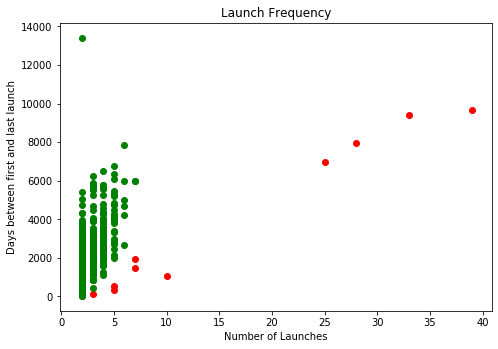

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
xt = ComponentLaunchIntervals[(ComponentLaunchIntervals["LaunchCount"]>1)].unstack(["type"])
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(xt["LaunchCount","craft"], xt["TotalLaunchInterval","craft"].astype('timedelta64[D]'), color='r')
ax.scatter(xt["LaunchCount","traveller"], xt["TotalLaunchInterval","traveller"].astype('timedelta64[D]'), color='g')
ax.set_xlabel('Number of Launches')
ax.set_ylabel('Days between first and last launch')
ax.set_title('Launch Frequency')
plt.show()

<h2>Flight Duration</h2>

Lets look into the duration of missions and spaceflights. Start by adding a duration column to the component state table.

In [11]:
dfcs["duration"] = dfcs["enddate"] - dfcs["startdate"]
dfcs[(dfcs["component"]=="Neil_Armstrong")]

,startevent,startdate,enddate,component,type,mission,orbit,pred,succ,duration
362,Neil_Armstrong JOINS Gemini_8,1966-03-16,1966-03-16 00:00:00.000000,Neil_Armstrong,traveller,Gemini_8,None,NaN,364.0,0 days 00:00:00
364,Gemini_8 DEPARTS Earth,1966-03-16,1966-03-16 00:00:00.000000,Neil_Armstrong,traveller,Gemini_8,Leaving_Earth,362.0,367.0,0 days 00:00:00
367,Gemini_8 ARRIVES LEO,1966-03-16,1966-03-17 00:00:00.000000,Neil_Armstrong,traveller,Gemini_8,LEO,364.0,370.0,1 days 00:00:00
370,Gemini_8 DEPARTS LEO,1966-03-17,1966-03-17 00:00:00.000000,Neil_Armstrong,traveller,Gemini_8,Leaving_LEO,367.0,373.0,0 days 00:00:00
373,Gemini_8 ARRIVES Earth,1966-03-17,1969-07-16 00:00:00.000000,Neil_Armstrong,traveller,Gemini_8,Earth,370.0,716.0,1217 days 00:00:00
716,Neil_Armstrong JOINS Apollo_11,1969-07-16,1969-07-16 00:00:00.000000,Neil_Armstrong,traveller,Apollo_11,None,373.0,719.0,0 days 00:00:00
719,Apollo_11 DEPARTS Earth,1969-07-16,1969-07-16 00:00:00.000000,Neil_Armstrong,traveller,Apollo_11,Leaving_Earth,716.0,724.0,0 days 00:00:00
724,Apollo_11 ARRIVES LEO,1969-07-16,1969-07-16 00:00:00.000000,Neil_Armstrong,traveller,Apollo_11,LEO,719.0,729.0,0 days 00:00:00
729,Apollo_11 DEPARTS LEO,1969-07-16,1969-07-19 00:00:00.000000,Neil_Armstrong,traveller,Apollo_11,Leaving_LEO,724.0,734.0,3 days 00:00:00
734,Apollo_11 ARRIVES Lunar_Orbit,1969-07-19,1969-07-20 00:00:00.000000,Neil_Armstrong,traveller,Apollo_11,Lunar_Orbit,729.0,740.0,1 days 00:00:00


Total durations.
Include all component states where the orbit is not Earth or None.
Sum durations for each component.

In [12]:
componentDurations = dfcs.loc[(dfcs["orbit"]!="Earth")&(dfcs["orbit"].apply(lambda x: x is not None)),["component","duration","type"]]\
.groupby(by=["component","type"])\
.sum()\
.sort_values(by="duration", ascending=False)
componentDurations.reset_index("type", inplace=True)
componentDurations.rename(columns = {"duration":"TotalTimeInSpace"}, inplace=True)
componentDurations

,type,TotalTimeInSpace
component,,
Zarya,craft,7836 days 12:28:02.500793
Unity,craft,7822 days 12:28:02.509961
Zvezda,craft,7236 days 12:28:02.617795
Destiny,craft,7026 days 12:28:02.693223
Quest,craft,6871 days 12:28:02.762866
...,...,...
OK-1K1,craft,0 days 00:00:00
New_Shepard_3,craft,0 days 00:00:00
New_Shepard_2,craft,0 days 00:00:00


Travellers

In [13]:
travellerDurations = componentDurations[(componentDurations["type"]=="traveller")]
travellerDurations.head(20)

,type,TotalTimeInSpace
component,,
Gennady_Padalka,traveller,878 days
Yuri_Malenchenko,traveller,825 days
Sergei_Krikalev,traveller,803 days
Aleksandr_Kaleri,traveller,769 days
Sergei_Avdeyev,traveller,744 days
Oleg_Kononenko,traveller,738 days
Valeri_Polyakov,traveller,679 days
Fyodor_Yurchikhin,traveller,675 days
Peggy_Whitson,traveller,667 days


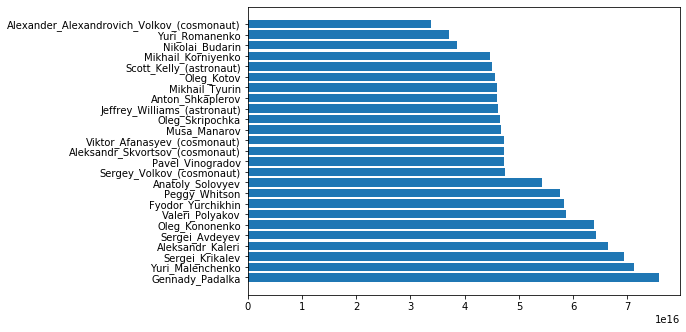

In [14]:
T = travellerDurations.head(25)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(T.index.values,T["TotalTimeInSpace"])
plt.show()

Repeating for spacecraft

In [15]:
craftDurations = componentDurations[(componentDurations["type"]=="craft")]
craftDurations

,type,TotalTimeInSpace
component,,
Zarya,craft,7836 days 12:28:02.500793
Unity,craft,7822 days 12:28:02.509961
Zvezda,craft,7236 days 12:28:02.617795
Destiny,craft,7026 days 12:28:02.693223
Quest,craft,6871 days 12:28:02.762866
...,...,...
Shenzhou_5 Spacecraft,craft,0 days 00:00:00
Orion MPCV EFT-1,craft,0 days 00:00:00
OK-1K1,craft,0 days 00:00:00


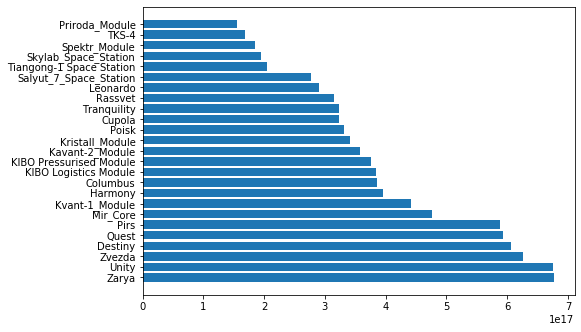

In [16]:
C = craftDurations.head(25)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(C.index,C["TotalTimeInSpace"])
plt.show()

<h2>Simaltaneous flights</h2>

I'm interested in how much "bigger" space missions have gotten over the years.

First add a column to the mission status to count the number of components and travellers.

In [17]:
def compcount(x):
    if x is not None:
        return len(x)
    else:
        return 0
dfms["crcount"] = dfms["craft"].apply(lambda x: compcount(x))
dfms["tvcount"] = dfms["travellers"].apply(lambda x: compcount(x))
dfms.sort_values(by="tvcount", ascending=False).head(5)

,startevent,mission,startdate,enddate,orbit,craft,travellers,pred,succ,crcount,tvcount
6591,Alan_G._Poindexter JOINS International_Space_S...,International_Space_Station,2010-04-07,2010-04-20,LEO,"[Zarya, Unity, Zvezda, Destiny, Quest, Pirs, H...","[Timothy_Creamer, Soichi_Noguchi, Oleg_Kotov, ...",6589.0,6594.0,16,13
4078,SPACEHAB LDM SUPPORTS STS-89,Mir,1998-01-29,1998-01-29,LEO,"[Mir_Core, Kvant-1_Module, Kavant-2_Module, Kr...","[Pavel_Vinogradov, Anatoly_Solovyev, David_A._...",4076.0,4080.0,8,13
4076,Space_Shuttle_Endeavour SUPPORTS STS-89,Mir,1998-01-29,1998-01-29,LEO,"[Mir_Core, Kvant-1_Module, Kavant-2_Module, Kr...","[Pavel_Vinogradov, Anatoly_Solovyev, David_A._...",4073.0,4078.0,9,13
4794,Dennis_Tito JOINS International_Space_Station,International_Space_Station,2001-04-29,2001-05-01,LEO,"[Zarya, Unity, Zvezda, Soyuz_TM-31_Spacecraft,...","[Yury_Usachev, Susan_Helms, James_S._Voss, Yur...",4792.0,4797.0,7,13
4073,L%C3%A9opold_Eyharts JOINS Mir,Mir,1998-01-29,1998-01-29,LEO,"[Mir_Core, Kvant-1_Module, Kavant-2_Module, Kr...","[Pavel_Vinogradov, Anatoly_Solovyev, David_A._...",4071.0,4076.0,10,13


Several of these are zero duration states. I think this happens where a crew joins a space station, a new state is created each time a crew member is added. If many happen at the same time, many zero duration states are created. Although.. if a crew hand-over occurred on a single day, that would also produce zero duration states.

In [18]:
dfms["duration"] = dfms["enddate"] - dfms["startdate"]
dfms[(dfms["duration"]>pd.Timedelta(0))&(dfms["orbit"]!="Earth")&(dfms["orbit"].apply(lambda x: x is not None))].sort_values(by="tvcount", ascending=False).head(10)[["mission","travellers","tvcount","startdate","duration"]]

,mission,travellers,tvcount,startdate,duration
6366,International_Space_Station,"[Michael_R._Barratt, Gennady_Padalka, Roman_Ro...",13,2009-08-30,12 days
6317,International_Space_Station,"[Koichi_Wakata, Michael_R._Barratt, Gennady_Pa...",13,2009-07-17,14 days
4794,International_Space_Station,"[Yury_Usachev, Susan_Helms, James_S._Voss, Yur...",13,2001-04-29,2 days
6227,International_Space_Station,"[Yuri_Lonchakov, Michael_Fincke, Sandra_Magnus...",13,2009-03-28,1 days
6591,International_Space_Station,"[Timothy_Creamer, Soichi_Noguchi, Oleg_Kotov, ...",13,2010-04-07,13 days
5636,International_Space_Station,"[Pavel_Vinogradov, Jeffrey_Williams_(astronaut...",12,2006-09-20,1 days
6840,International_Space_Station,"[Paolo_Nespoli, Dmitri_Kondratyev, Catherine_G...",12,2011-05-18,6 days
6642,International_Space_Station,"[Timothy_Creamer, Soichi_Noguchi, Oleg_Kotov, ...",12,2010-05-16,7 days
6769,International_Space_Station,"[Scott_Kelly_(astronaut), Oleg_Skripochka, Ale...",12,2011-02-26,9 days
6442,International_Space_Station,"[Roman_Romanenko, Robert_Thirsk, Frank_De_Winn...",12,2009-11-18,9 days


I could plot this...

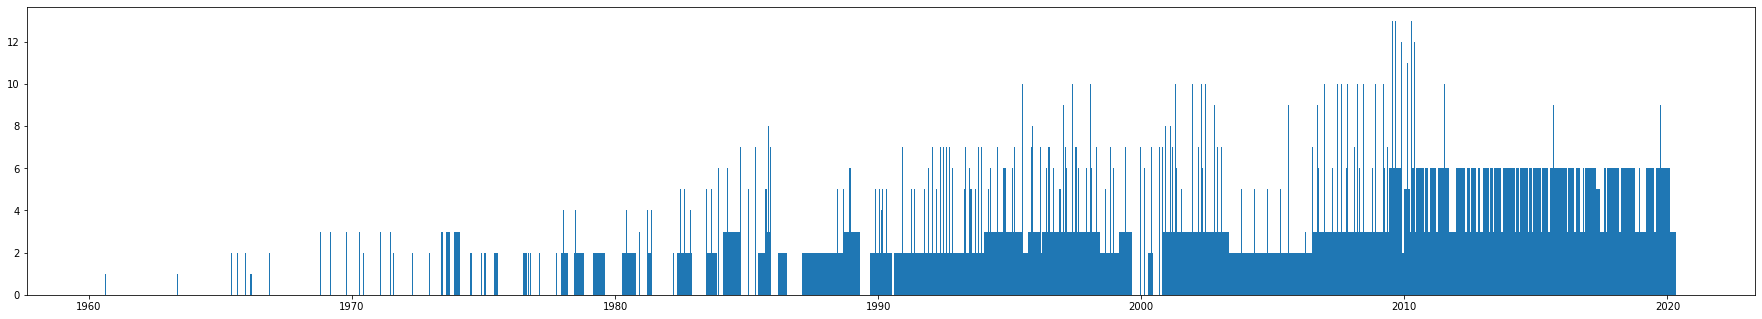

In [19]:
nzdurationms = dfms[(dfms["duration"]>pd.Timedelta(0))&(dfms["orbit"]!="Earth")&(dfms["orbit"].apply(lambda x: x is not None))]
fig = plt.figure()
ax = fig.add_axes([0,0,4,1])
ax.bar(x=nzdurationms["startdate"], height=nzdurationms["tvcount"], width=nzdurationms["duration"], align="edge")
plt.show()

I'd like to colour code my charts by "program" i.e. all Apollo, all Soyuz etc. First I need to categorise the missions into programs. Note that some (rarely, I can only think of Apollo-Soyuz-Test-Project) of these search terms overlap, in which case it belongs to the last one to claim it.

In [20]:
progmap = [("Apollo","Apollo"),
           ("Mercury","Mercury"),
           ("Gemini","Gemini"),
           ("STS","Space_Shuttle"),
           ("Soyuz","Soyuz"),
           ("Vostok","Vostok"),
           ("Voskhod","Voskhod"),
           ("X-15","X-15"),
           ("Sputnik","Sputnik"),
           ("Kosmos","Kosmos"),
           ("Skylab","Skylab"),
           ("Zond","Zond"),
           ("Salyut","Salyut"),
           ("Shenzhou","Shenzhou"),
           ("Tiangong","Tiangong"),
           ("SpaceShipOne","Ansari_X_Prize"),
           ("New_Shepard","Blue_Origin"),
           ("International_Space_Station","International_Space_Station"),
           ("Zvezda","International_Space_Station"),
           ("Progress","International_Space_Station"),
           ("AS-","Apollo"),
           ("Mir","Mir"),
           ("Kvant-1","Mir"),
           ("Kavant-2","Mir"),
           ("Spektr","Mir"),
           ("Priroda","Mir"),
           ("Kristall","Mir"),
           ("Kavant-2","Mir"),
           ("Buran","Buran"),
           ("CRS","CRS"),
           ("Crew_Dragon","CCP"),
           ("Exploration_Flight_Test","Orion")]
for p in progmap:
    m.loc[pd.Series(m.index).apply(lambda x: p[0] in x).to_list(),"program"] = p[1]

# Check for left-overs
m.loc[(m["program"].apply(lambda x: pd.isnull(x)))]

,orbit,currentstate,craft,travellers,program
Boe-OFT,Earth,7916,[Boeing_Starliner_Spacecraft_3],None,NaN


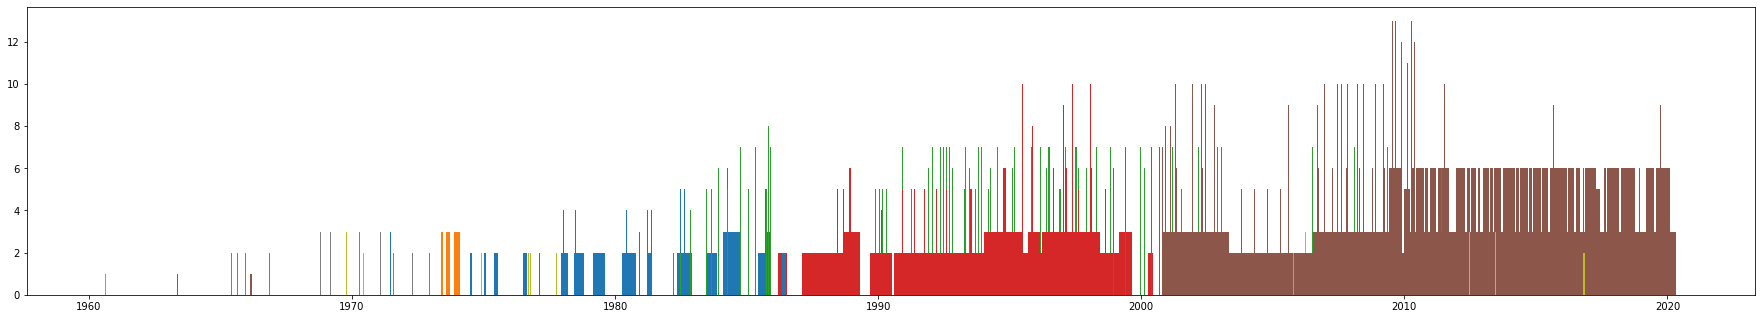

In [21]:
dfX = nzdurationms.join(m["program"], on="mission")
fig = plt.figure()
ax = fig.add_axes([0,0,4,1])
progs = m["program"].unique()
for p in progs:
    dfY = dfX.loc[dfX["program"]==p]
    ax.bar(x=dfY["startdate"], height=dfY["tvcount"], width=dfY["duration"], align="edge")
plt.show()

Repeating for craft. Shows how space stations have gotten a lot bigger over the years.

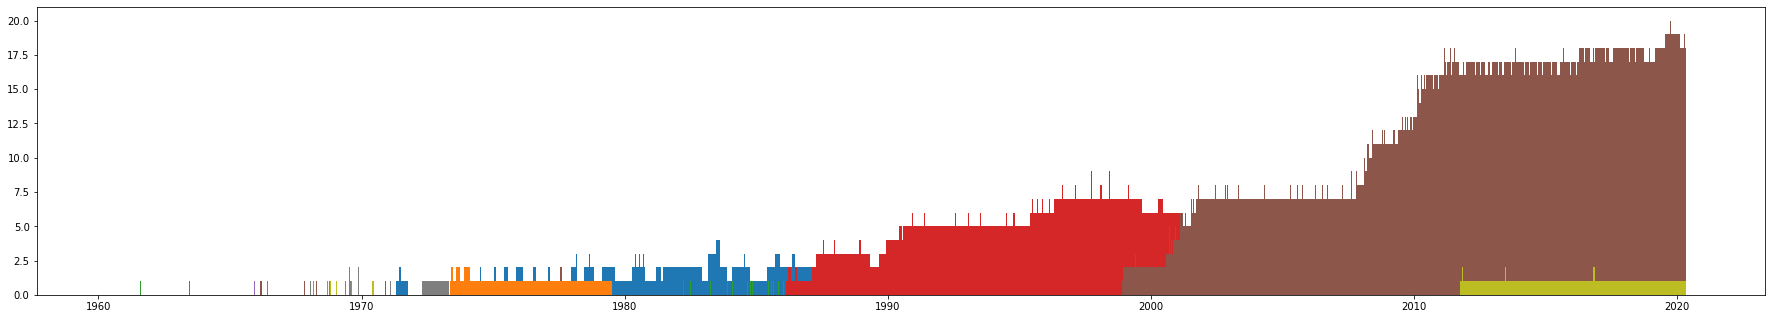

In [22]:
dfX = nzdurationms.join(m["program"], on="mission")
fig = plt.figure()
ax = fig.add_axes([0,0,4,1])
progs = m["program"].unique()
for p in progs:
    dfY = dfX.loc[dfX["program"]==p]
    ax.bar(x=dfY["startdate"], height=dfY["crcount"], width=dfY["duration"], align="edge")
plt.show()

So doing a bit of guesswork, I suppose brown in ISS, red is Mir, blue Salyut, orange Skylab, green Shuttle, yellow Tiangong. Not sure about the others.

<h2>Flights</h2>

Try and group together component states into "flights". I.e. all states that are sequential that don't involve Earth. Note that components very often jump missions in orbit so need to group across missions.

In [23]:
# Algorythm for clustering component states into "flights".
# A flight is a continuous sequence of states where the component is away from Earth.
csflights = pd.Series(dtype="int")
for comp in c.index.to_list():
    # First select all states belonging to a component where the component is away from earth. Sort by sequence (index).
    flightstates = dfcs[(dfcs["component"]==comp)&(dfcs["orbit"]!="Earth")&(dfcs["orbit"].apply(lambda x: not(pd.isnull(x))))].sort_index()
    # Then compare the sequence id (index) to the successor id from the row above.
    # This is achived by shifting down the succ column by one and doing elementwise comparison.
    # In the event of a sequence break (i.e. start of next is greater than end of previous) the elementwise comparison will be True.
    # The cumsum operation is a running sum. False is 0 and True is 1, so it will only increment in the event of a break.
    flights = pd.Series((flightstates.index > flightstates["succ"].shift()).cumsum(), index=flightstates.index)
    csflights = csflights.append(flights)
csflights.name = "flight"
dfcs = pd.concat([dfcs,csflights],ignore_index=False, axis=1)
dfcs

,startevent,startdate,enddate,component,type,mission,orbit,pred,succ,duration,flight
0,Mercury_No.4 SUPPORTS Mercury-Atlas_1,1960-07-29,1960-07-29 00:00:00.000000,Mercury_No.4,craft,Mercury-Atlas_1,None,NaN,1.0,0 days 00:00:00,NaN
1,Mercury-Atlas_1 DEPARTS Earth,1960-07-29,1960-07-29 00:00:00.000000,Mercury_No.4,craft,Mercury-Atlas_1,Leaving_Earth,0.0,2.0,0 days 00:00:00,0.0
2,Mercury-Atlas_1 ARRIVES Sub_Orbital,1960-07-29,1960-07-29 00:00:00.000000,Mercury_No.4,craft,Mercury-Atlas_1,Sub_Orbital,1.0,3.0,0 days 00:00:00,0.0
3,Mercury-Atlas_1 ENDS nan,1960-07-29,2020-05-04 12:28:00.324767,Mercury_No.4,craft,None,None,2.0,NaN,21829 days 12:28:00.324767,NaN
4,Vostok_1K_KS2 SUPPORTS Korabl-Sputnik_2,1960-08-19,1960-08-19 00:00:00.000000,Vostok_1K_KS2,craft,Korabl-Sputnik_2,None,NaN,7.0,0 days 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10746,Soyuz_MS-15 DEPARTS LEO,2020-04-17,2020-04-17 00:00:00.000000,Soyuz_MS-15_Spacecraft,craft,Soyuz_MS-15,Leaving_LEO,10739.0,10750.0,0 days 00:00:00,0.0
10747,Soyuz_MS-15 ARRIVES Earth,2020-04-17,2020-05-04 12:28:04.053019,Andrew_R._Morgan,traveller,Soyuz_MS-15,Earth,10743.0,NaN,17 days 12:28:04.053019,NaN
10748,Soyuz_MS-15 ARRIVES Earth,2020-04-17,2020-05-04 12:28:04.053121,Oleg_Skripochka,traveller,Soyuz_MS-15,Earth,10744.0,NaN,17 days 12:28:04.053121,NaN
10749,Soyuz_MS-15 ARRIVES Earth,2020-04-17,2020-05-04 12:28:04.053220,Jessica_Meir,traveller,Soyuz_MS-15,Earth,10745.0,NaN,17 days 12:28:04.053220,NaN


In [24]:
dfcs[(dfcs["component"]=="LM_Eagle")]

,startevent,startdate,enddate,component,type,mission,orbit,pred,succ,duration,flight
715,LM_Eagle SUPPORTS Apollo_11,1969-07-16,1969-07-16 00:00:00.000000,LM_Eagle,craft,Apollo_11,None,NaN,723.0,0 days 00:00:00,NaN
723,Apollo_11 DEPARTS Earth,1969-07-16,1969-07-16 00:00:00.000000,LM_Eagle,craft,Apollo_11,Leaving_Earth,715.0,728.0,0 days 00:00:00,0.0
728,Apollo_11 ARRIVES LEO,1969-07-16,1969-07-16 00:00:00.000000,LM_Eagle,craft,Apollo_11,LEO,723.0,733.0,0 days 00:00:00,0.0
733,Apollo_11 DEPARTS LEO,1969-07-16,1969-07-19 00:00:00.000000,LM_Eagle,craft,Apollo_11,Leaving_LEO,728.0,738.0,3 days 00:00:00,0.0
738,Apollo_11 ARRIVES Lunar_Orbit,1969-07-19,1969-07-20 00:00:00.000000,LM_Eagle,craft,Apollo_11,Lunar_Orbit,733.0,739.0,1 days 00:00:00,0.0
739,LM_Eagle SUPPORTS Apollo_11#Landing,1969-07-20,1969-07-20 00:00:00.000000,LM_Eagle,craft,Apollo_11#Landing,Lunar_Orbit,738.0,744.0,0 days 00:00:00,0.0
744,Apollo_11#Landing DEPARTS Lunar_Orbit,1969-07-20,1969-07-20 00:00:00.000000,LM_Eagle,craft,Apollo_11#Landing,Leaving_Lunar_Orbit,739.0,747.0,0 days 00:00:00,0.0
747,Apollo_11#Landing ARRIVES Lunar_Surface,1969-07-20,1969-07-21 00:00:00.000000,LM_Eagle,craft,Apollo_11#Landing,Lunar_Surface,744.0,750.0,1 days 00:00:00,0.0
750,Apollo_11#Landing DEPARTS Lunar_Surface,1969-07-21,1969-07-21 00:00:00.000000,LM_Eagle,craft,Apollo_11#Landing,Leaving_Lunar_Surface,747.0,753.0,0 days 00:00:00,0.0
753,Apollo_11#Landing ARRIVES Lunar_Orbit,1969-07-21,1969-07-21 00:00:00.000000,LM_Eagle,craft,Apollo_11#Landing,Lunar_Orbit,750.0,754.0,0 days 00:00:00,0.0


In [73]:
componentflights = dfcs[["component","type","startdate","enddate","duration","flight","orbit","mission"]].groupby(by=["component","type","flight"])\
.agg({"startdate":"min","enddate":"max","duration":"sum","orbit":"unique","mission":"unique"})
componentflights.sort_values(by="duration", ascending=False).head(40)

,,,startdate,enddate,duration,orbit,mission
component,type,flight,,,,,
Zarya,craft,0.0,1998-11-20,2020-05-04 12:28:02.500794,7836 days 12:28:02.500793,"[Leaving_Earth, LEO]",[International_Space_Station]
Unity,craft,0.0,1998-12-04,2020-05-04 12:28:02.509962,7822 days 12:28:02.509961,"[Leaving_Earth, LEO]","[STS-88, International_Space_Station]"
Zvezda,craft,0.0,2000-07-12,2020-05-04 12:28:02.617796,7236 days 12:28:02.617795,"[Leaving_Earth, LEO]","[Zvezda_(ISS_module), International_Space_Stat..."
Destiny,craft,0.0,2001-02-07,2020-05-04 12:28:02.693224,7026 days 12:28:02.693223,"[Leaving_Earth, LEO]","[STS-98, International_Space_Station]"
Quest,craft,0.0,2001-07-12,2020-05-04 12:28:02.762867,6871 days 12:28:02.762866,"[Leaving_Earth, LEO]","[STS-104, International_Space_Station]"
Pirs,craft,0.0,2001-09-14,2020-05-04 12:28:02.793512,6807 days 12:28:02.793511,"[Leaving_Earth, LEO]","[Progress_M-SO1, International_Space_Station]"
Mir_Core,craft,0.0,1986-02-20,2001-03-23 00:00:00.000000,5510 days 00:00:00,"[Leaving_Earth, LEO, Leaving_LEO, Sub_Orbital]",[Mir]
Kvant-1_Module,craft,0.0,1987-03-30,2001-03-23 00:00:00.000000,5107 days 00:00:00,"[Leaving_Earth, LEO, Leaving_LEO, Sub_Orbital]","[Kvant-1, Mir]"
Harmony,craft,0.0,2007-10-23,2020-05-04 12:28:03.199460,4577 days 12:28:03.199459,"[Leaving_Earth, LEO]","[STS-120, International_Space_Station]"


Various stats on component flights. Duty is the percentage of the time between the first launch and final landing that the component was in space.

In [74]:
cflightgroups = componentflights[["duration", "startdate", "enddate"]].groupby(by=["component","type"])
cflightstats = cflightgroups.agg({"startdate":"min","enddate":"max","duration":["count","max","min","sum"]})
cflightstats[("duration","mean")] = cflightgroups.apply(lambda x: np.mean(x))
cflightstats = cflightstats.reset_index("type")
cflightstats["periodactive"] = cflightstats[("enddate","max")] - cflightstats[("startdate","min")]
cflightstats["duty"] = cflightstats[("duration","sum")] / cflightstats["periodactive"]


/Users/simon/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py:580: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


Who was the busiest space traveller?

In [76]:
cflightstats[(cflightstats["type"]=="traveller")&(cflightstats[("duration","count")]>1)].sort_values(by="duty", ascending=False).head(30)


type  startdate    enddate duration  \
                                                  min        max    count   
component                                                                   
Nick_Hague                       traveller 2018-10-11 2019-10-03        2   
Musa_Manarov                     traveller 1987-12-21 1991-05-26        2   
Vladimir_Solovyov_(cosmonaut)    traveller 1984-02-04 1986-07-16        2   
Yuri_Usachyev                    traveller 1994-01-08 1996-09-02        2   
Valeri_Ryumin                    traveller 1977-10-09 1980-10-11        3   
Michael_R._Barratt               traveller 2009-03-26 2011-03-09        2   
Aleksey_Ovchinin                 traveller 2016-03-18 2019-10-03        3   
Sergei_Avdeyev                   traveller 1992-07-27 1999-08-28        3   
Gennadi_Manakov                  traveller 1990-08-03 1993-07-22        2   
Valeri_Polyakov                  traveller 1988-08-29 1995-03-22        2   
Yuri_Gidzenko                    traveller 2000-10-31 2002-05-05        2   
Mikhail_Korniyenko               traveller 2010-04-02 2016-03-02        2   
Aleksandr_Samokutyayev           traveller 2011-04-04 2015-03-12        2   
Leonid_Popov                     traveller 1980-04-09 1982-08-27        3   
Roman_Romanenko                  traveller 2009-05-27 2013-05-14        2   
Anton_Shkaplerov                 traveller 2011-11-14 2018-06-03        3   
Oleg_Artemyev                    traveller 2014-03-25 2018-10-04        2   
Alexander_Gerst                  traveller 2014-05-28 2018-12-20        2   
Oleg_Kotov                       traveller 2007-04-07 2014-03-11        3   
Oleg_Novitskiy                   traveller 2012-10-23 2017-06-02        2   
Sergey_Ryazansky                 traveller 2013-09-25 2017-12-14        2   
Susan_L._Still                   traveller 1997-04-04 1997-07-17        2   
Roger_K._Crouch                  traveller 1997-04-04 1997-07-17        2   
Gregory_T._Linteris              traveller 1997-04-04 1997-07-17        2   
Sergey_Volkov_(cosmonaut)        traveller 2008-04-08 2016-03-02        3   
Aleksandr_Pavlovich_Aleksandrov  traveller 1983-06-26 1987-12-29        2   
Alexander_Misurkin               traveller 2013-03-28 2018-02-28        2   
Nicole_P._Stott                  traveller 2009-08-28 2011-03-09        2   
Yelena_Kondakova                 traveller 1994-10-04 1997-05-24        2   
Leonid_Kizim                     traveller 1980-11-27 1986-07-16        3   

                                                                              \
                                     max      min      sum              mean   
component                                                                      
Nick_Hague                      203 days   0 days 203 days 101 days 12:00:00   
Musa_Manarov                    366 days 175 days 541 days 270 days 12:00:00   
Vladimir_Solovyov_(cosmonaut)   241 days 125 days 366 days 183 days 00:00:00   
Yuri_Usachyev                   194 days 182 days 376 days 188 days 00:00:00   
Valeri_Ryumin                   185 days   2 days 362 days 120 days 16:00:00   
Michael_R._Barratt              199 days  13 days 212 days 106 days 00:00:00   
Aleksey_Ovchinin                203 days   0 days 376 days 125 days 08:00:00   
Sergei_Avdeyev                  378 days 177 days 744 days 248 days 00:00:00   
Gennadi_Manakov                 179 days 129 days 308 days 154 days 00:00:00   
Valeri_Polyakov                 438 days 241 days 679 days 339 days 12:00:00   
Yuri_Gidzenko                   141 days  10 days 151 days  75 days 12:00:00   
Mikhail_Korniyenko              341 days 176 days 517 days 258 days 12:00:00   
Aleksandr_Samokutyayev          168 days 165 days 333 days 166 days 12:00:00   
Leonid_Popov                    185 days   8 days 201 days  67 days 00:00:00   
Roman_Romanenko                 188 days 146 days 334 days 167 days 00:00:00   
Anton_Shkaplerov                200 days 165 days 533 da

Hmm, not sure Nick Hague really did two flights, more like one and a bit.

Which was the busiest re-usable spacecraft?

In [77]:
cflightstats[(cflightstats["type"]=="craft")&(cflightstats[("duration","count")]>1)].sort_values(by="duty", ascending=False)


type  startdate    enddate duration          \
                                       min        max    count     max   
component                                                                
SPACEHAB LSM              craft 2006-12-10 2007-08-21        2 13 days   
Space_Shuttle_Challenger  craft 1983-04-04 1986-02-28       10  8 days   
SPACEHAB LDM              craft 1996-09-16 2000-09-19        7 11 days   
Space_Shuttle_Endeavour   craft 1992-05-07 2011-06-01       25 16 days   
Space_Shuttle_Discovery   craft 1984-08-30 2011-03-09       39 15 days   
Space_Shuttle_Columbia    craft 1981-04-12 2003-02-01       28 18 days   
SPACEHAB SM               craft 1993-06-21 1998-11-07        7 10 days   
Space_Shuttle_Atlantis    craft 1985-10-03 2011-07-21       33 14 days   
Mercury_No.8              craft 1961-04-25 1961-09-13        2  0 days   
New_Shepard_2             craft 2015-11-23 2016-10-05        5  0 days   
New_Shepard_3             craft 2017-12-12 2019-05-02        5  0 days   
SpaceShipOne_X0           craft 2004-06-21 2004-10-04        3  0 days   
VA 102L                   craft 1978-03-30 1979-05-22        2  0 days   
VA 102P                   craft 1978-03-30 1979-05-22        2  0 days   
X-15 No.3                 craft 1963-07-19 1963-08-22        2  0 days   

                                                                   \
                             min      sum                    mean   
component                                                           
SPACEHAB LSM             12 days  25 days        12 days 12:00:00   
Space_Shuttle_Challenger  0 days  62 days         6 days 04:48:00   
SPACEHAB LDM              9 days  70 days        10 days 00:00:00   
Space_Shuttle_Endeavour   6 days 296 days        11 days 20:09:36   
Space_Shuttle_Discovery   3 days 367 days  9 days 09:50:46.153846   
Space_Shuttle_Columbia    2 days 300 days 10 days 17:08:34.285714   
SPACEHAB SM               8 days  64 days  9 days 03:25:42.857142   
Space_Shuttle_Atlantis    4 days 306 days  9 days 06:32:43.636363   
Mercury_No.8              0 days   0 days         0 days 00:00:00   
New_Shepard_2             0 days   0 days         0 days 00:00:00   
New_Shepard_3             0 days   0 days         0 days 00:00:00   
SpaceShipOne_X0           0 days   0 days         0 days 00:00:00   
VA 102L                   0 days   0 days         0 days 00:00:00   
VA 102P                   0 days   0 days         0 days 00:00:00   
X-15 No.3                 0 days   0 days         0 days 00:00:00   

                         periodactive      duty  
                                                 
component                                        
SPACEHAB LSM                 254 days  0.098425  
Space_Shuttle_Challenger    1061 days  0.058435  
SPACEHAB LDM                1464 days  0.047814  
Space_Shuttle_Endeavour     6964 days  0.042504  
Space_Shuttle_Discovery     9687 days  0.037886  
Space_Shuttle_Columbia      7965 days  0.037665  
SPACEHAB SM                 1965 days  0.032570  
Space_Shuttle_Atlantis      9422 days  0.032477  
Mercury_No.8                 141 days  0.000000  
New_Shepard_2                317 days  0.000000  
New_Shepard_3                506 days  0.000000  
SpaceShipOne_X0              105 days  0.000000  
VA 102L                      418 days  0.000000  
VA 102P                      418 days  0.000000  
X-15 No.3                     34 days  0.000000

Want to graphically investigate the distribution of the above now...

In [79]:
componentflights = componentflights.reset_index("type")

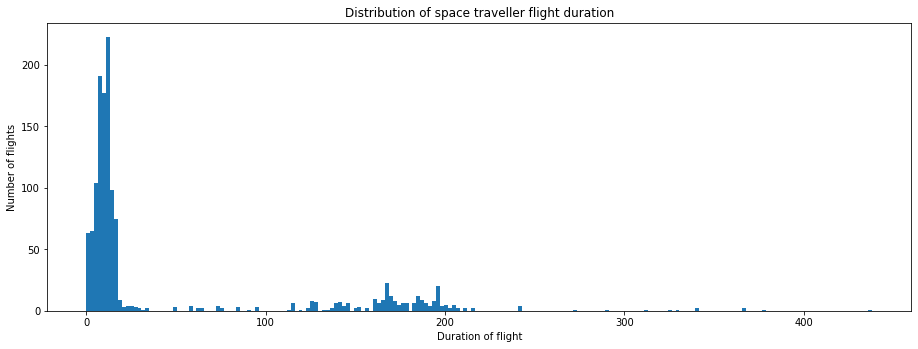

In [82]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.hist(componentflights.loc[(componentflights["type"]=="traveller"),"duration"].astype('timedelta64[D]'),200)
ax.set_ylabel('Number of flights')
ax.set_xlabel('Duration of flight')
ax.set_title('Distribution of space traveller flight duration')
plt.show()


So the vast majority of space flights have lasted (for their travellers) for less than a month. There is a second peak around 6 months.

Repeat for spacecraft

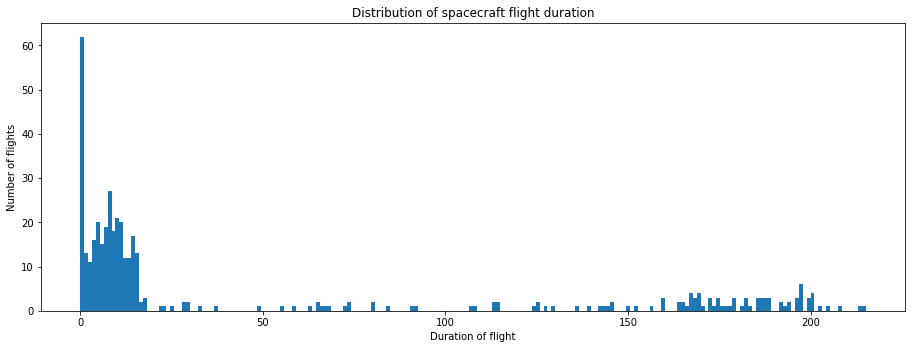

In [81]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.hist(componentflights.loc[((componentflights["type"]=="craft")&(componentflights["duration"] < pd.Timedelta(365, unit="D"))),"duration"].astype('timedelta64[D]'),200)
ax.set_ylabel('Number of flights')
ax.set_xlabel('Duration of flight')
ax.set_title('Distribution of spacecraft flight duration')
plt.show()


Ignoring the small number of flights that last more than a year. Similar to people, mostly 1 month or less with a second peak at 6 months.